In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import s3fs
import scipy.stats
import time
import multiprocessing as mp
import matplotlib.pylab as plt

import pandas as pd
import numpy as np
import scipy
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import ast
import glob
import json
import os

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

import torch
import torch.nn as nn

In [7]:
def get_data(path_to_data,fs):
    
    Data = []
    
    for gesture in list_of_gesture_paths:
        single_gesture_data = featurize_one_gesture(gesture,fs)
        Data = Data + single_gesture_data
    
    return Data

def mp_get_data(path_to_data,fs):
    
    Data = []
    data_params = []
    
    for gesture in list_of_gesture_paths:
        data_params.append((gesture,fs))

    pool = mp.Pool(processes=8)
    Data = pool.map(featurize_one_gesture, data_params)
    
    Data = [i for gestures in Data for i in gestures]
    
    return Data

def featurize_one_gesture(params):
    gesture_path = params[0]
    fs = params[1]
    
    current_gesture_data = read_gesture_data(fs, gesture_path)
    label = current_gesture_data["gesture"][0]
    data = []
    
    for i in range(len(current_gesture_data)):
        data.append(get_acceleration_data(current_gesture_data,i,label))
    
    return data

def get_acceleration_data(current_gesture_data, row_index, label):
    
    acceleration = [i[0:3] for i in current_gesture_data.iloc[row_index].motion]
    acceleration = pd.DataFrame(acceleration)
    features = get_accleration_timeseries(acceleration)
    params = [features, label, np.arange(0,100,10)]
    features = featurize(params)
    return features


def read_gesture_data(fs,gesture_path):
    
    examples = []
    files = fs.ls(gesture_path)
    for file in files:
        with fs.open(file) as f:
            opened_file = json.loads(f.read())
        
        examples.append(opened_file)
    
    examples = pd.io.json.json_normalize(examples)
    
    return examples 

def featurize(params):
    ts = params[0]
    label = params[1]
    bins = params[2]
    mean = np.mean(ts)
    median = np.median(ts)
    std = np.std(ts)
    length = len(ts)
    kurtosis = scipy.stats.kurtosis(ts)
    
    return (ts, label)
    
    n,b,p = plt.hist(ts, bins=bins)
    n = np.array(n)/float(np.sum(n)) #normalize i.e. fraction of entries in each bin
    
    if median == 0: 
        features = {'mean_over_median': 0, #dimensionless            
                    'std_over_median': 0, #dimensionless            
                    'length': length,
                    'kurtosis': kurtosis, #already dimensionless by definition
                   }
        
    else: 
        features = {'mean_over_median': mean/median, #dimensionless            
            'std_over_median': std/median, #dimensionless            
            'length': length,
            'kurtosis': kurtosis, #already dimensionless by definition
           }
        
    for i, val in enumerate(n):
        features[f'binfrac_{i}'] = val
    
    features['label'] = label
    
    return features
    
def get_accleration_timeseries(timeseries):
    return timeseries
    timeseries = timeseries.apply((lambda x: x**2))
    timeseries = timeseries.sum(axis=1)
    timeseries = timeseries.apply(np.sqrt)
    
    return timeseries # 1xn Series  
  

In [8]:
path_to_data = "cchase-rh-demo-4/training-data"
#fs = s3fs.S3FileSystem()
fs = s3fs.S3FileSystem(key=os.environ['AWSACCESSKEYID'], secret=os.environ['AWSSECRETACCESSKEY'])
list_of_gesture_paths = fs.ls(path_to_data)
Data = mp_get_data(list_of_gesture_paths,fs)

/home/sanjay/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sanjay/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/sanjay/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sanjay/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/sanjay/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sanjay/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/sanjay/.local/lib/python3.6/site-packages/numpy/core/fromnumeric

In [12]:
data = {}
for d in Data:
    if d[1] not in data:
        data[d[1]] = []
    data[d[1]].append(d[0])

In [18]:
for d in data:
    print (d, len(data[d]))

draw-circle 55
draw-triangle 49
fever 50
floss 52
roll 56
shake 53


In [41]:
label = 'draw-circle'
acc_ts = []
for d in data[label]:
    if d.shape[0]<10:
        continue
    
    acc_ts.append(np.sqrt((d**2).sum(axis=1)).tolist())

<IPython.core.display.Javascript object>


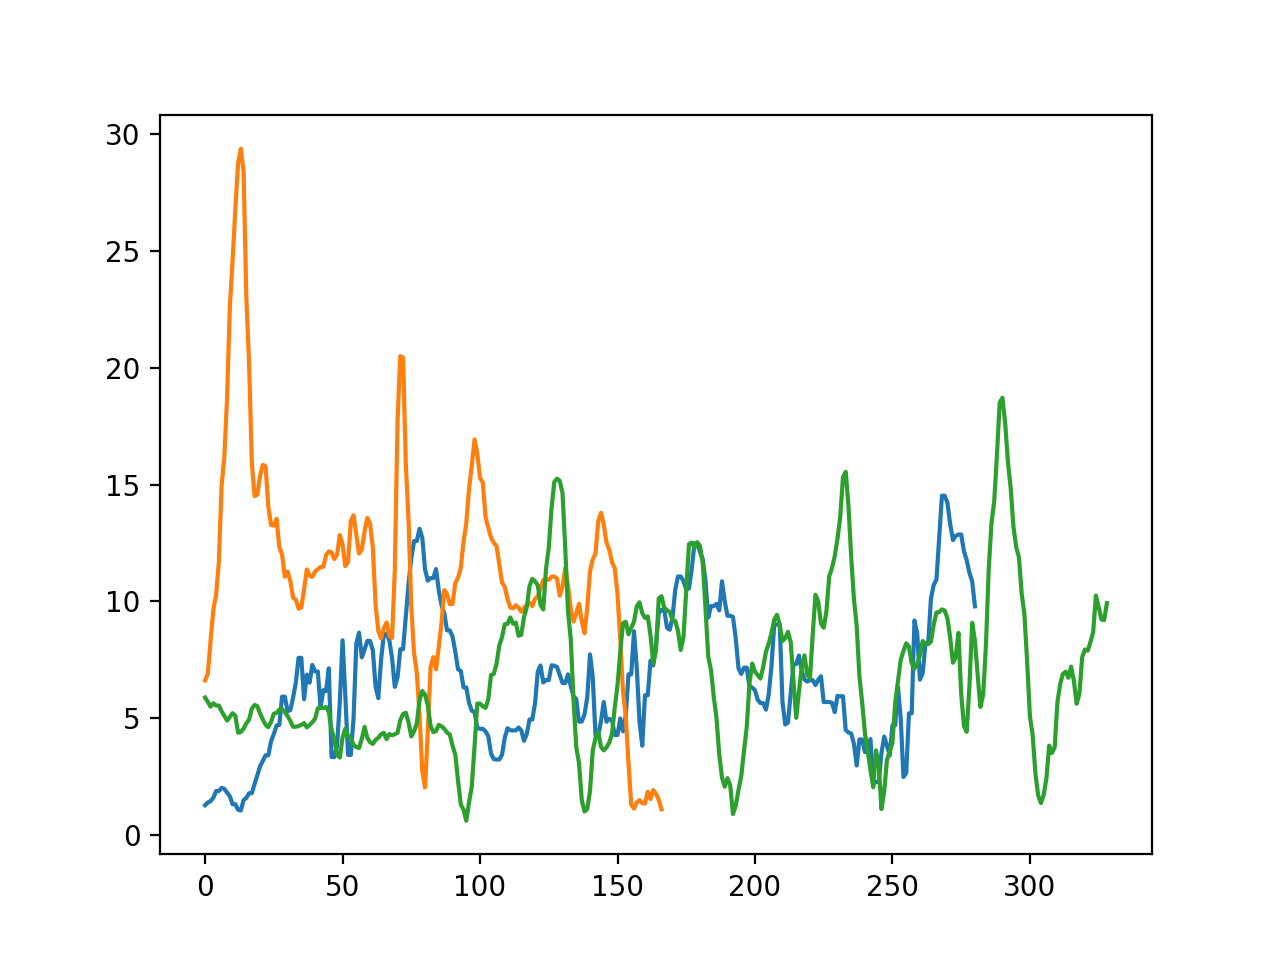

In [42]:
plt.figure()
plt.plot(acc_ts[15])
plt.plot(acc_ts[5])
plt.plot(acc_ts[20])

In [145]:
label = 'floss'
acc_ts = []
for d in data[label]:
    if d.shape[0]<10:
        continue
    
    #acc_ts.append(np.abs(np.array(d[2])))
    #acc_ts.append(np.abs(d[2]/d[0]))
    #acc_ts.append(np.sqrt((d**2).sum(axis=1)).tolist())
    acc_ts.append((d[1], d[2]))

<IPython.core.display.Javascript object>


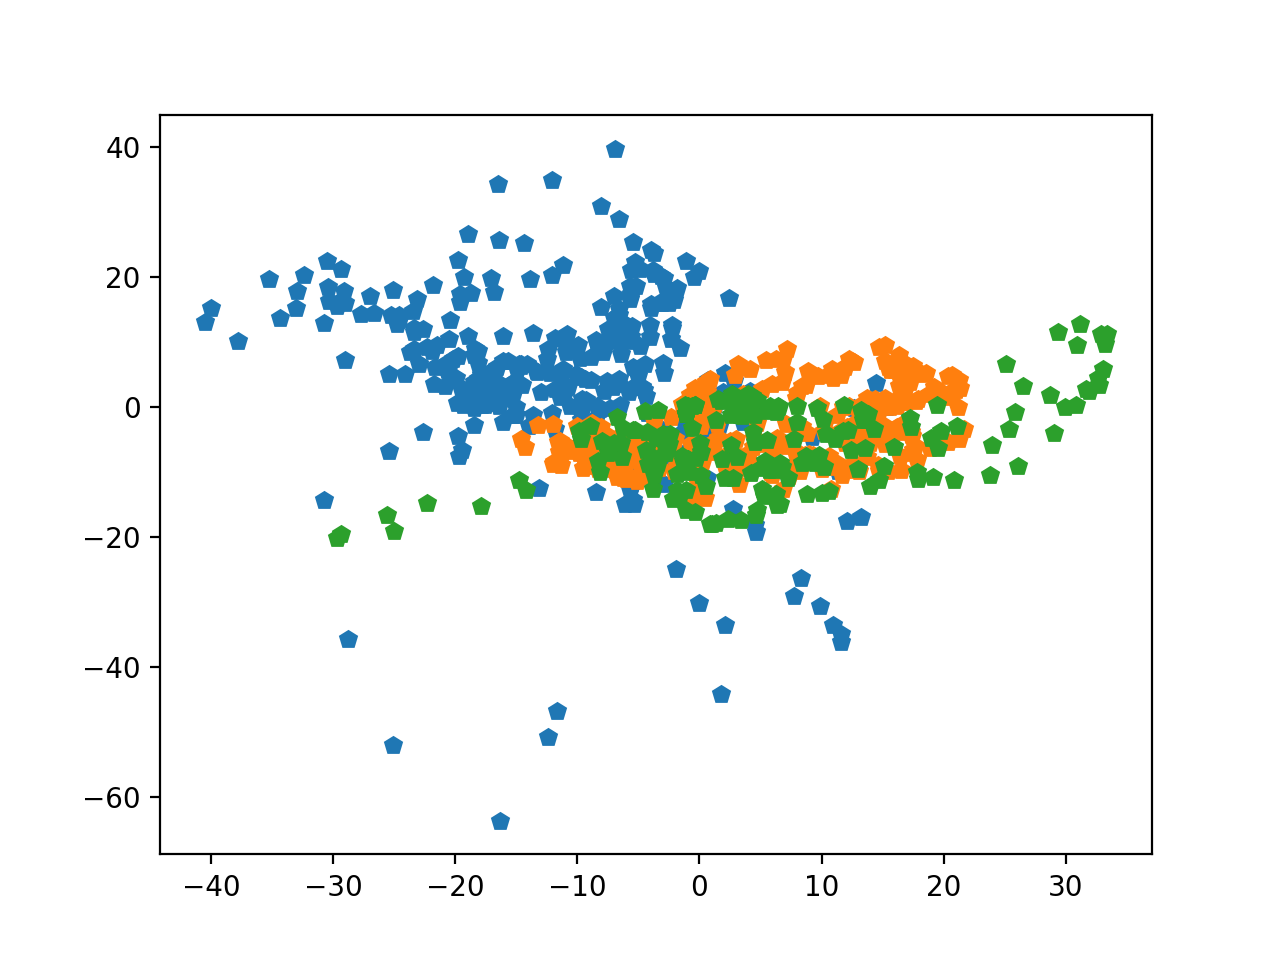

In [146]:
plt.figure()
#plt.plot(acc_ts[15])
plt.plot(acc_ts[15][0], acc_ts[15][1], 'p')
plt.plot(acc_ts[10][0], acc_ts[10][1], 'p')
plt.plot(acc_ts[5][0], acc_ts[5][1], 'p')
#plt.plot(acc_ts[20])

In [143]:
label = 'draw-triangle'
acc_ts = []
for d in data[label]:
    if d.shape[0]<10:
        continue
    
    #acc_ts.append(np.abs(np.array(d[2])))
    #acc_ts.append(np.abs(d[2]/d[0]))
    #acc_ts.append(np.sqrt((d**2).sum(axis=1)).tolist())
    acc_ts.append((d[1], d[2]))

<IPython.core.display.Javascript object>


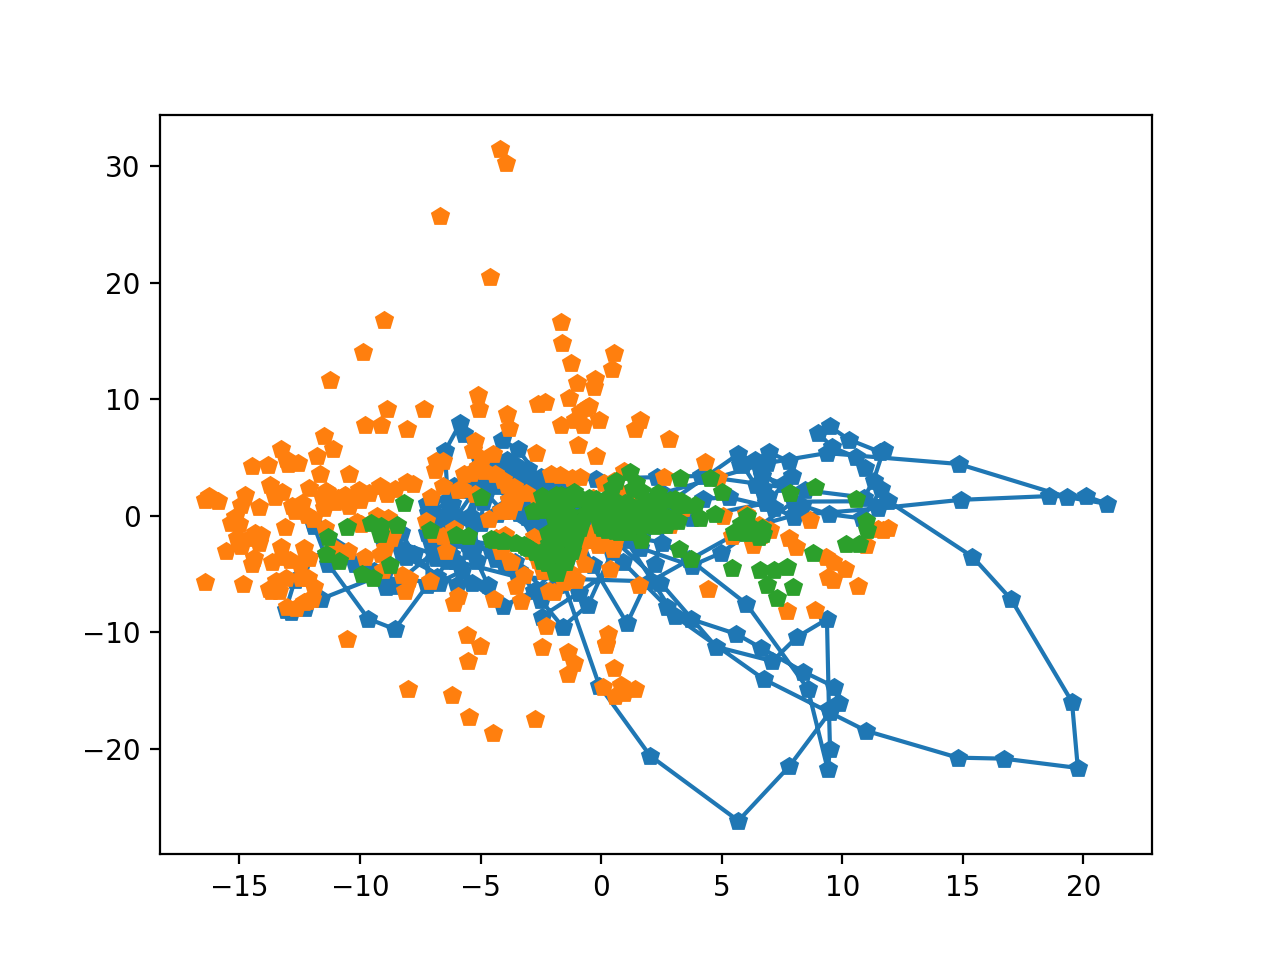

In [144]:
plt.figure()
#plt.plot(acc_ts[15])
plt.plot(acc_ts[15][0], acc_ts[15][1], 'p-')
plt.plot(acc_ts[10][0], acc_ts[10][1], 'p')
plt.plot(acc_ts[5][0], acc_ts[5][1], 'p')
#plt.plot(acc_ts[20])

In [47]:
label = 'roll'
acc_ts = []
for d in data[label]:
    if d.shape[0]<10:
        continue
    
    acc_ts.append(np.sqrt((d**2).sum(axis=1)).tolist())

<IPython.core.display.Javascript object>


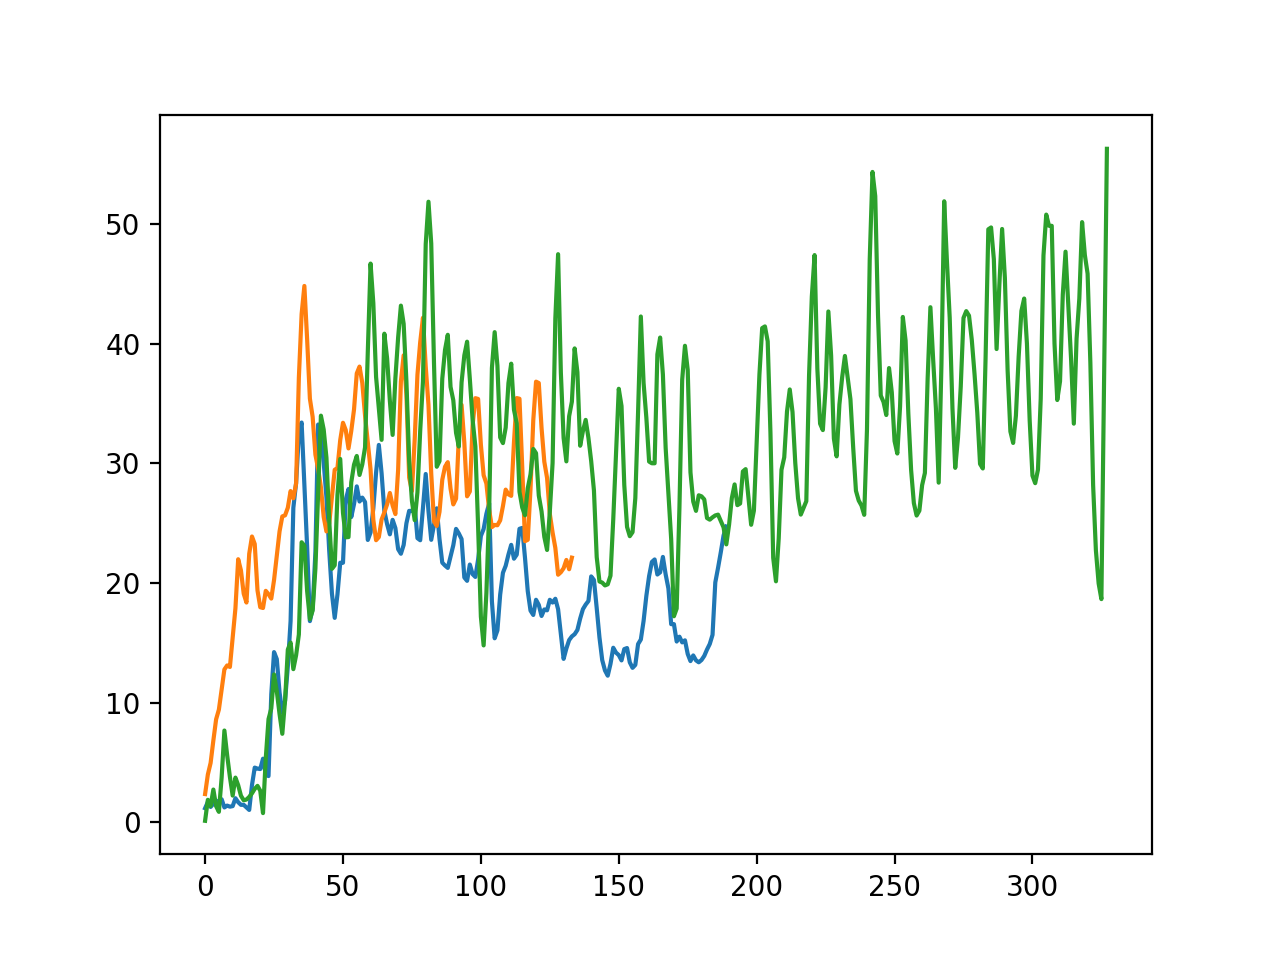

In [48]:
plt.figure()
plt.plot(acc_ts[15])
plt.plot(acc_ts[5])
plt.plot(acc_ts[20])

In [194]:
def normalize_ts(df_ts):
    acc = np.array(np.sqrt((df_ts**2).sum(axis=1)))
    
    acc_max = np.max(acc)
    
    acc = acc / acc_max
    
    return acc

def ratio_ts(df_ts):
    acc = df_ts[(df_ts[numer]!=0) & (df_ts[denom]!=0)]
    
    ratio = df_ts[numer] / df_ts[denom]
    
    return ratio

def featurize_ts(ts, bins=np.arange(0,1,0.1), tag='MAGNITUDE'):
    mean = np.mean(ts)
    median = np.median(ts)
    std = np.std(ts)
    length = len(ts)
    kurtosis = scipy.stats.kurtosis(ts)
    
    n,b = np.histogram(ts, bins=bins)
    n = np.array(n)/float(np.sum(n)) #normalize i.e. fraction of entries in each bin
    
    if median == 0: 
        features = {f'{tag}_mean_over_median': 0, #dimensionless            
                    f'{tag}_std_over_median': 0, #dimensionless            
                    f'{tag}_length': length,
                    f'{tag}_kurtosis': kurtosis, #already dimensionless by definition
                   }
        
    else: 
        features = {f'{tag}_mean_over_median': mean/median, #dimensionless            
            f'{tag}_std_over_median': std/median, #dimensionless            
            f'{tag}_length': length,
            f'{tag}_kurtosis': kurtosis, #already dimensionless by definition
           }
        
    for i, val in enumerate(n):
        features[f'{tag}_binfrac_{i}'] = val
        
    return features
    
def create_df(data, transform_ts, tag, bins):
    features = []
    labels = []
    
    for d in data: #loop over keys
        print(d)
        if d=='draw-circle' or d=='draw-triangle':
            continue
        for elem in data[d]:
            if elem.shape[0] > 5:
                features.append(featurize_ts(transform_ts(elem), bins=bins, tag=tag))
                labels.append(d)
            
    features = pd.DataFrame(features)
    features['label'] = labels
    
    return features

def create_cv_data(df, train_size=0.75, random_state=None):
    train_df, test_df = train_test_split(df, train_size=train_size, random_state=random_state)
    print(f'train size = {train_df.shape}')
    print(f'test size = {test_df.shape}')

    return train_df, test_df

def train_sklearn_model(model, train_df, test_df):
    #train model
    model.fit(train_df.drop('label', axis=1), train_df['label'])

    train_pred = model.predict(train_df.drop('label', axis=1))
    train_labels = train_df['label']
    train_acc = np.sum(train_pred==train_labels) / len(train_pred)

    test_pred = model.predict(test_df.drop('label', axis=1))
    test_labels = test_df['label']
    test_acc = np.sum(test_pred==test_labels) / len(test_pred)

    print(f'train acc = {train_acc}, test_acc = {test_acc}')
    
    return model

def plot_confusion_matrix(train_labels, train_pred):
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot()

    labels = list(train_labels.value_counts().index)

    confusion = confusion_matrix(train_labels, train_pred, labels=labels)
    ax.matshow(confusion)

    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))

    ax.set_xticklabels(labels, rotation=90);
    ax.set_yticklabels(labels);

    for i in range(len(labels)):
        for j in range(len(labels)):        
            ax.text(j, i, confusion[i,j], va='center', ha='center')

    plt.xlabel('predicted')    
    plt.ylabel('true')
    
    return fig

In [195]:
featurize_ts(normalize_ts(data['floss'][50]))

{'MAGNITUDE_mean_over_median': 0.9920334946242951,
 'MAGNITUDE_std_over_median': 0.48920499295473124,
 'MAGNITUDE_length': 327,
 'MAGNITUDE_kurtosis': 0.510327677614264,
 'MAGNITUDE_binfrac_0': 0.10185185185185185,
 'MAGNITUDE_binfrac_1': 0.09567901234567901,
 'MAGNITUDE_binfrac_2': 0.09876543209876543,
 'MAGNITUDE_binfrac_3': 0.3117283950617284,
 'MAGNITUDE_binfrac_4': 0.19444444444444445,
 'MAGNITUDE_binfrac_5': 0.12037037037037036,
 'MAGNITUDE_binfrac_6': 0.04938271604938271,
 'MAGNITUDE_binfrac_7': 0.024691358024691357,
 'MAGNITUDE_binfrac_8': 0.0030864197530864196}

In [196]:
df1 = create_df(data, normalize_ts, 'MAGNITUDE', np.arange(0,1,0.1))

numer=0
denom=1
df2 = create_df(data, ratio_ts, 'RATIO_01', np.arange(0,20,4))

numer=0
denom=2
df3 = create_df(data, ratio_ts, 'RATIO_02', np.arange(0,20,4))

numer=1
denom=2
df4 = create_df(data, ratio_ts, 'RATIO_12', np.arange(0,20,4))

draw-circle
draw-triangle
fever
floss
roll


/home/sanjay/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


shake
draw-circle
draw-triangle
fever
floss
roll
shake
draw-circle
draw-triangle
fever
floss
roll
shake
draw-circle
draw-triangle
fever
floss
roll
shake


In [197]:
df = pd.concat([df1.drop('label', axis=1),df2.drop('label', axis=1), df3.drop('label', axis=1), df4], axis=1)

In [198]:
df.iloc[0]

MAGNITUDE_binfrac_0                0.12
MAGNITUDE_binfrac_1            0.171429
MAGNITUDE_binfrac_2            0.257143
MAGNITUDE_binfrac_3            0.182857
MAGNITUDE_binfrac_4           0.0571429
MAGNITUDE_binfrac_5           0.0571429
MAGNITUDE_binfrac_6           0.0514286
MAGNITUDE_binfrac_7           0.0742857
MAGNITUDE_binfrac_8           0.0285714
MAGNITUDE_kurtosis           -0.0311817
MAGNITUDE_length                    178
MAGNITUDE_mean_over_median      1.18874
MAGNITUDE_std_over_median      0.778336
RATIO_01_binfrac_0             0.949495
RATIO_01_binfrac_1             0.040404
RATIO_01_binfrac_2                    0
RATIO_01_binfrac_3             0.010101
RATIO_01_kurtosis               39.1675
RATIO_01_length                     178
RATIO_01_mean_over_median       -4.6229
RATIO_01_std_over_median         33.074
RATIO_02_binfrac_0             0.842105
RATIO_02_binfrac_1            0.0526316
RATIO_02_binfrac_2            0.0657895
RATIO_02_binfrac_3            0.0394737


In [199]:
print(df.shape)
print(df.dropna().shape)
df.dropna(inplace=True)

(207, 38)
(205, 38)


In [200]:
train_df, test_df = create_cv_data(df, train_size=0.50)

train size = (102, 38)
test size = (103, 38)


/home/sanjay/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [ ]:
model = RandomForestClassifier(max_depth=3, n_estimators=500, n_jobs=10, min_samples_leaf=8)

model = train_sklearn_model(model, train_df, test_df)

train_pred = model.predict(train_df.drop('label', axis=1))
train_labels = train_df['label']
train_acc = np.sum(train_pred==train_labels) / len(train_pred)

test_pred = model.predict(test_df.drop('label', axis=1))
test_labels = test_df['label']
test_acc = np.sum(test_pred==test_labels) / len(test_pred)

<IPython.core.display.Javascript object>


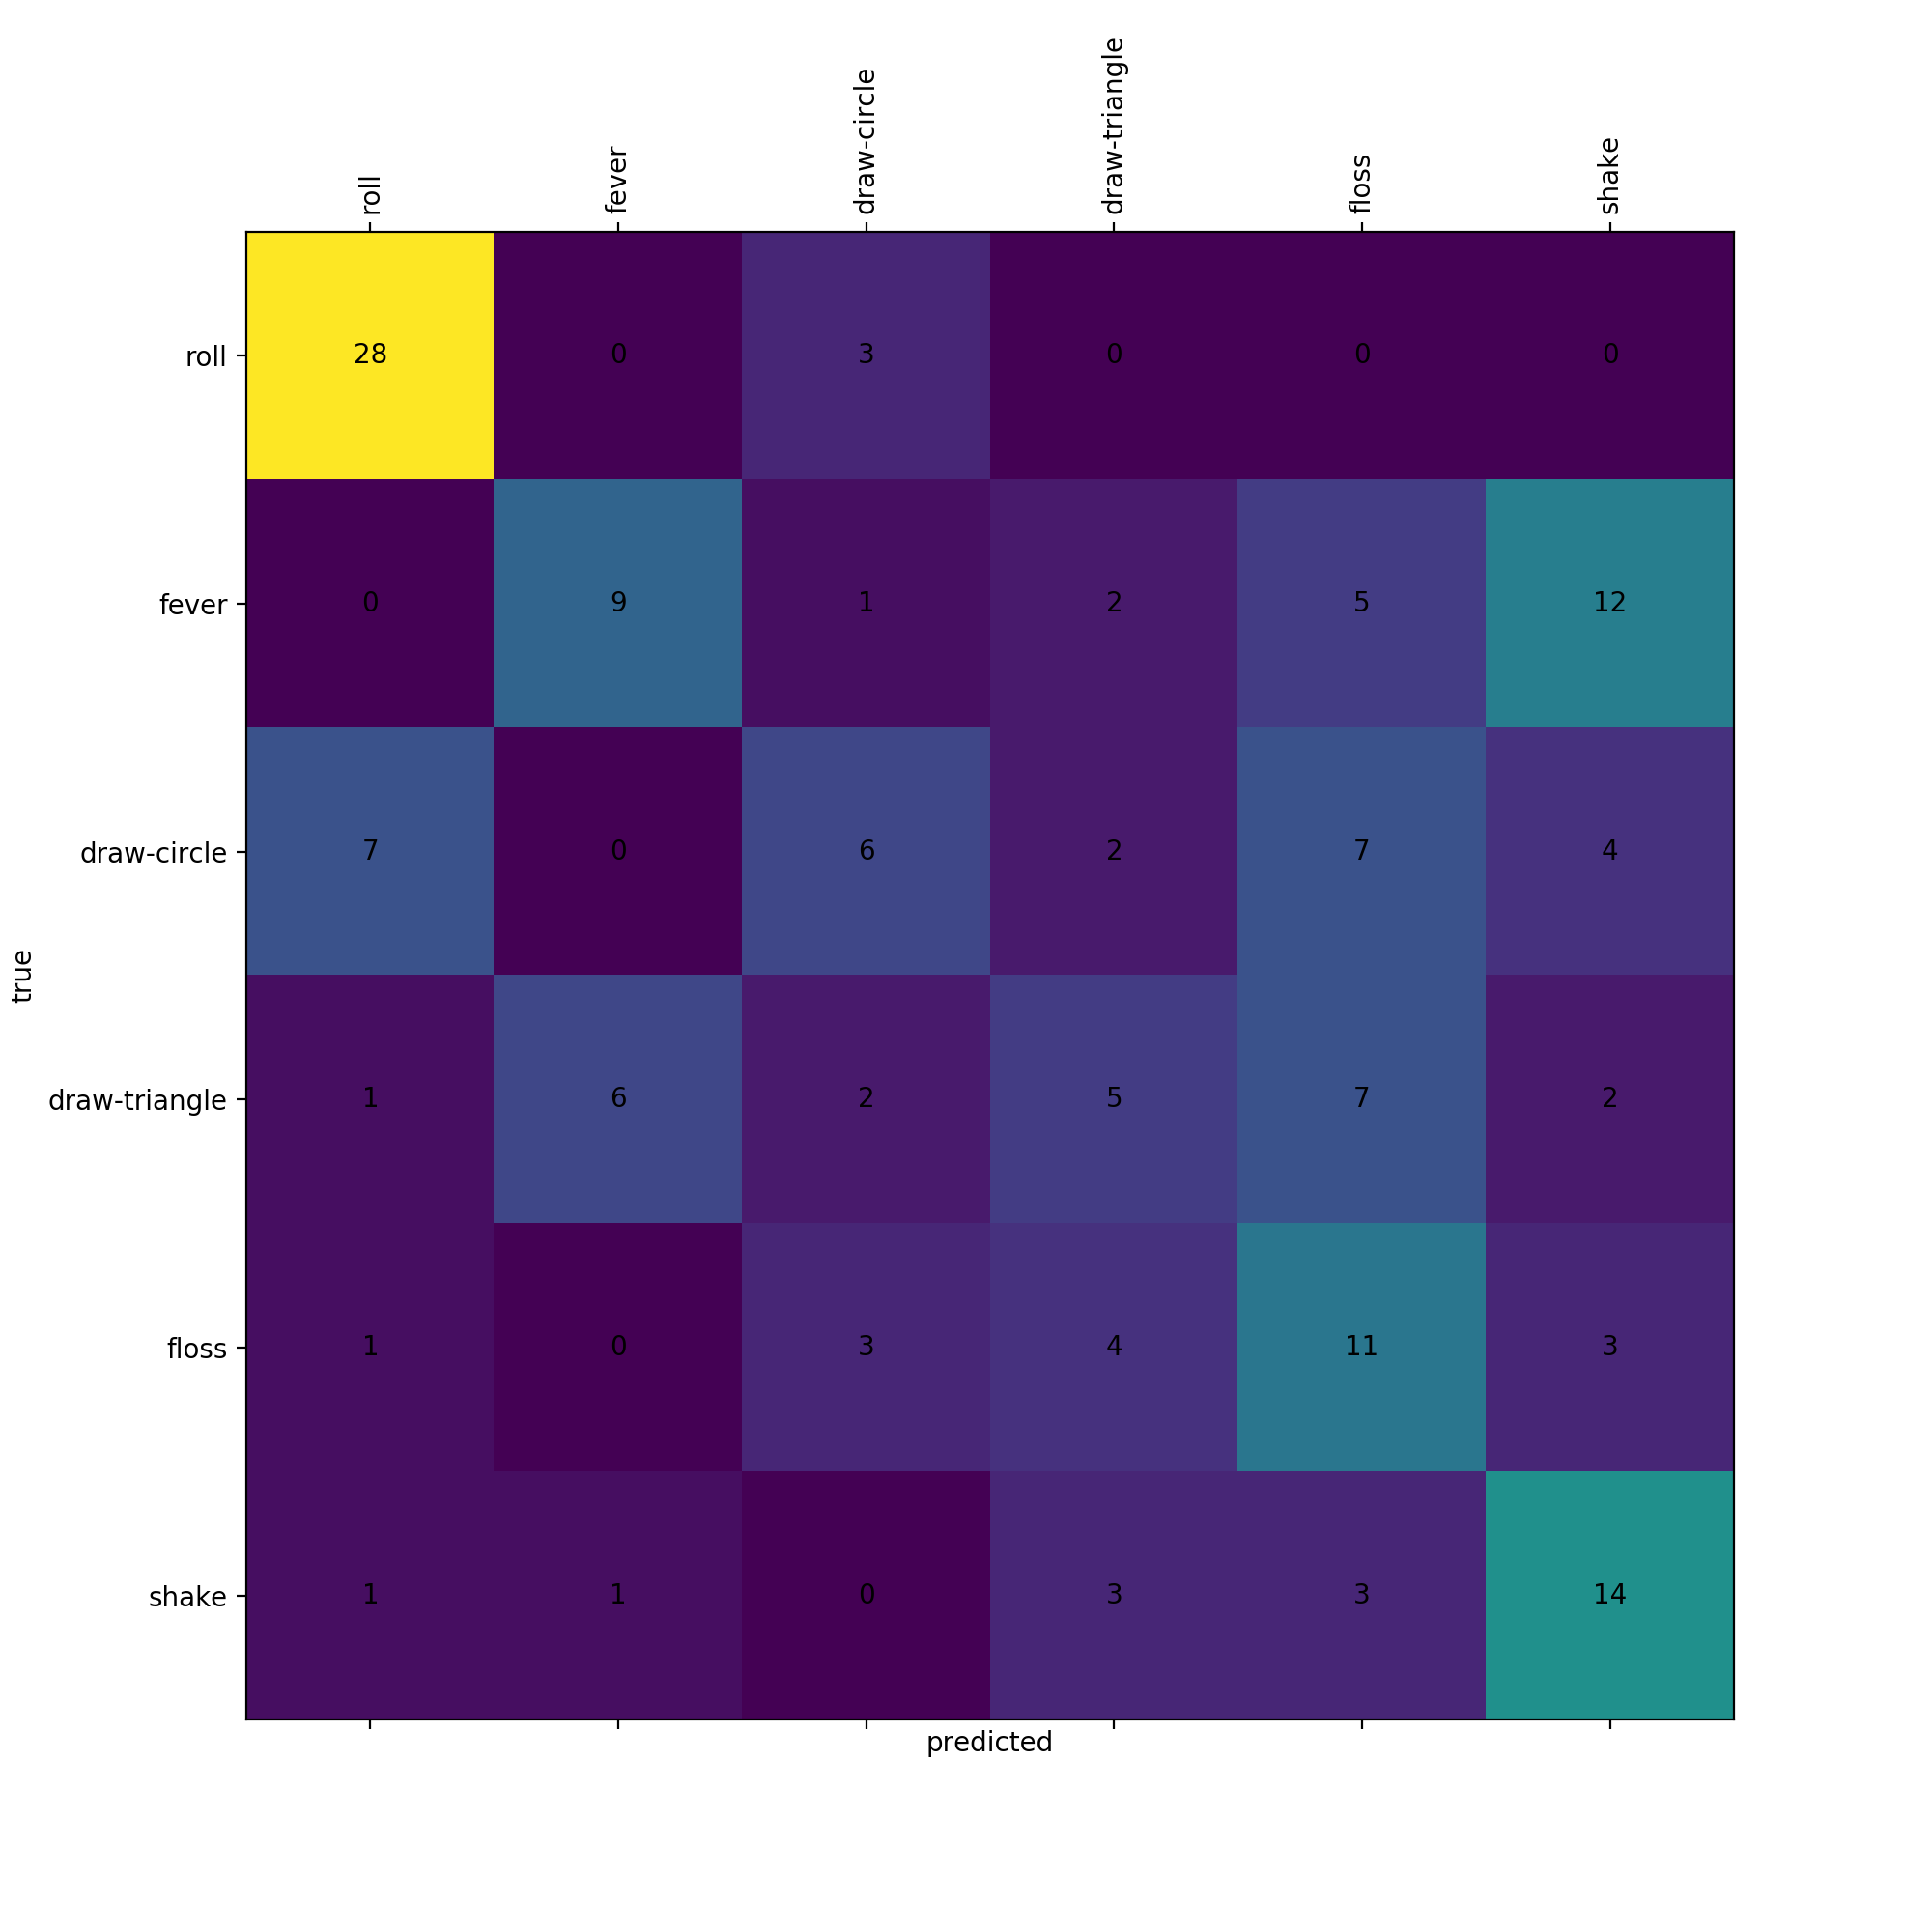

In [193]:
fig = plot_confusion_matrix(test_labels, test_pred)

In [112]:
np.sum((test_pred=='draw-triangle') & (test_labels=='floss'))

10

In [113]:
np.sum((test_pred=='floss') & (test_labels=='floss'))

6